# Deep Learning Model
- LSTM

## **Prepare Environment**

<br/>

### Imports

In [41]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Other
from IPython.display import Image
from time import time
import configparser
import subprocess
import warnings
import pprint
import os

# custom functions
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path

from utils import (
    path_to_work,
    plot_box_plot,
    save_image,
    save_dataframe,
    test_stationary,
    show_result_model,
)

### Prepare Principal Directory

In [42]:
path_to_work('notebooks')

'Current working directory: /Users/bruno.campos/projects/forecast-of-time-series-with-stock-data'

<br/>

### Set Config

In [43]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

plt.style.use('fivethirtyeight')

<br/>

### Load Data

In [45]:
%%time
df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                        encoding='utf8',
                        delimiter=',',
                        parse_dates=True,
                        index_col=0,
                        verbose=True)
print(df_vale3.info())
df_vale3.head()

Tokenization took: 2.97 ms
Type conversion took: 2.73 ms
Parser memory cleanup took: 0.01 ms
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2445 entries, 2010-07-12 to 2020-05-28
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   preco         2445 non-null   float64
 1   residuos      2445 non-null   float64
 2   tendencia     2445 non-null   float64
 3   sazonalidade  2445 non-null   float64
 4   diff_1        2445 non-null   float64
 5   diff_2        2445 non-null   float64
 6   diff_3        2445 non-null   float64
 7   diff_4        2445 non-null   float64
 8   diff_5        2445 non-null   float64
dtypes: float64(9)
memory usage: 191.0 KB
None
CPU times: user 15.6 ms, sys: 6.47 ms, total: 22.1 ms
Wall time: 21.3 ms


,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.00,1.00,41.83,1.00,-0.60,-0.46,0.49,0.98,0.42
2010-07-13,40.07,1.04,41.91,1.00,0.07,-0.53,-0.39,0.56,1.05
2010-07-14,40.08,1.03,41.98,1.00,0.01,0.08,-0.52,-0.38,0.57
2010-07-15,39.76,1.04,42.05,1.00,-0.32,-0.31,-0.24,-0.84,-0.70
2010-07-16,38.88,1.03,42.12,1.00,-0.88,-1.20,-1.19,-1.12,-1.72


## Split Data

In [46]:
size_train = 2132
size_test = 313
df_train = df_vale3.iloc[:size_train]
df_test = df_vale3.iloc[size_train:]
print(f'Total training = {size_train}')
print(f'Total testing = {size_test}')

Total training = 2132
Total testing = 313


Text(0.5, 1.0, 'Train size: 2132')

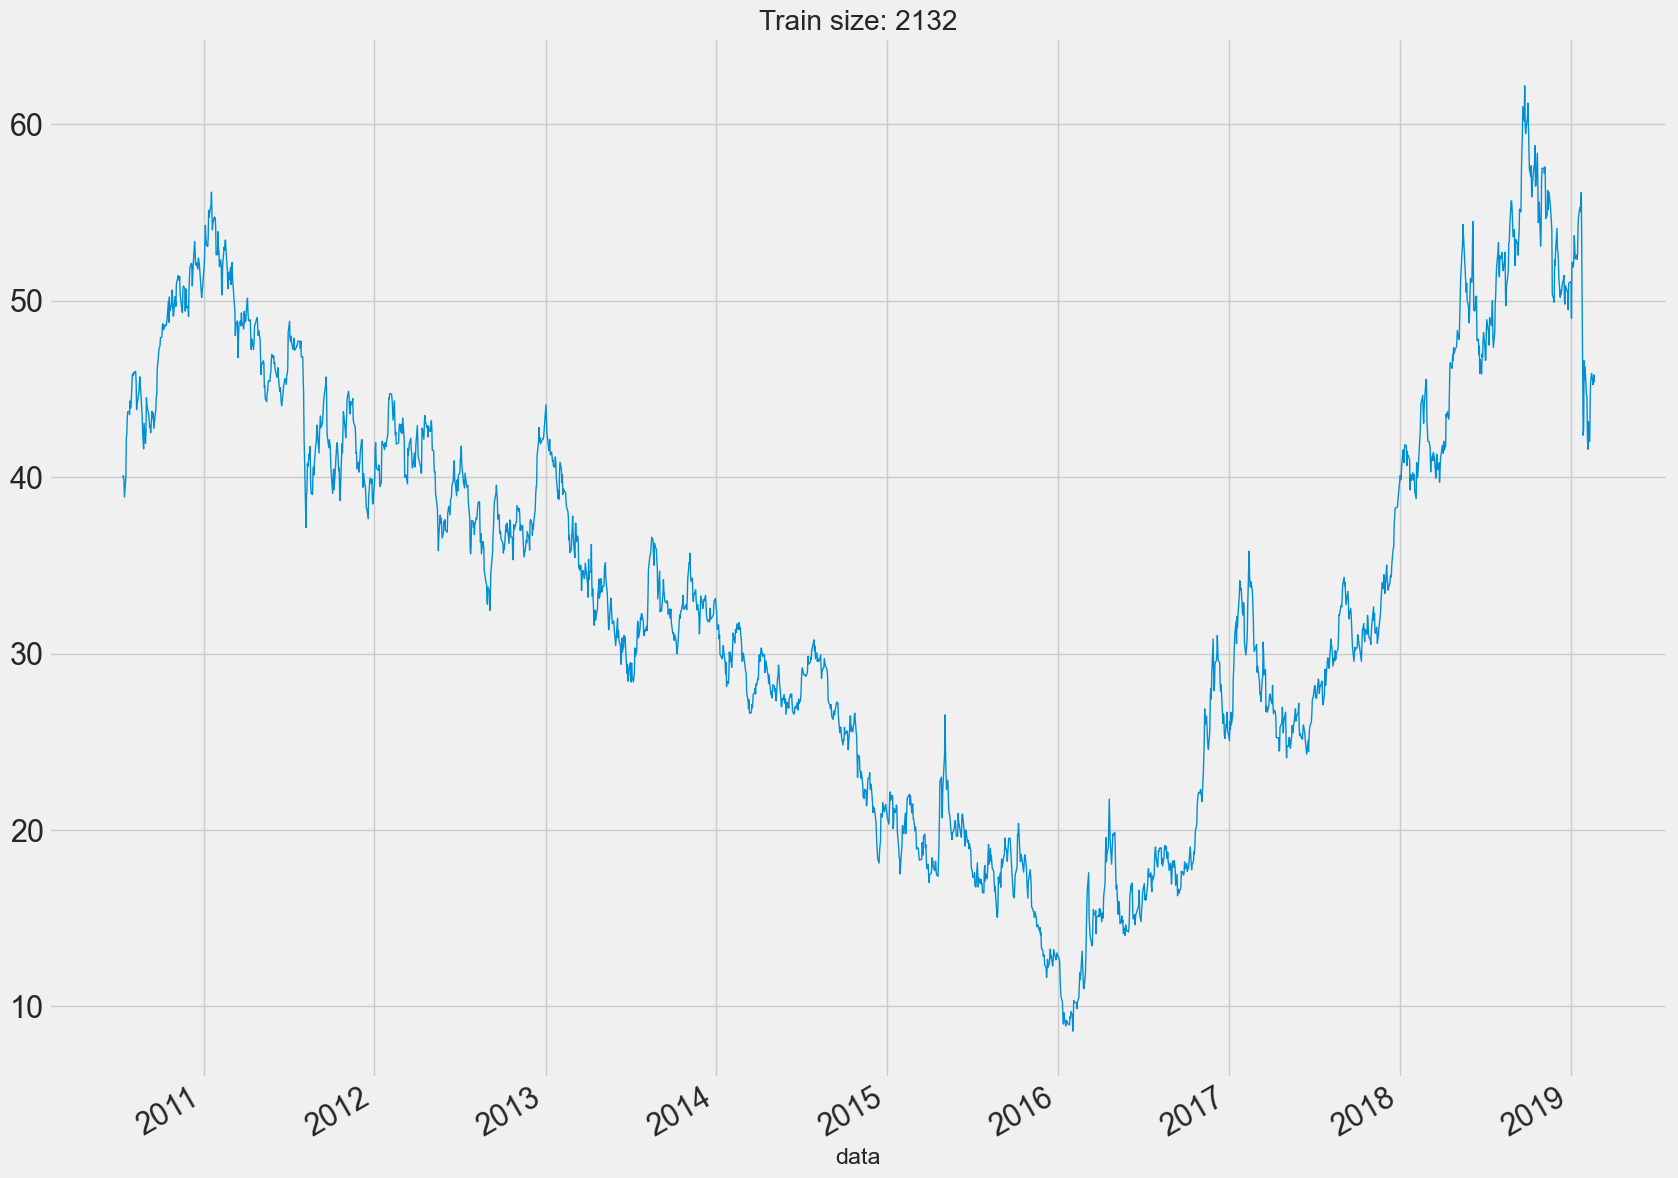

In [14]:
df_train['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 313')

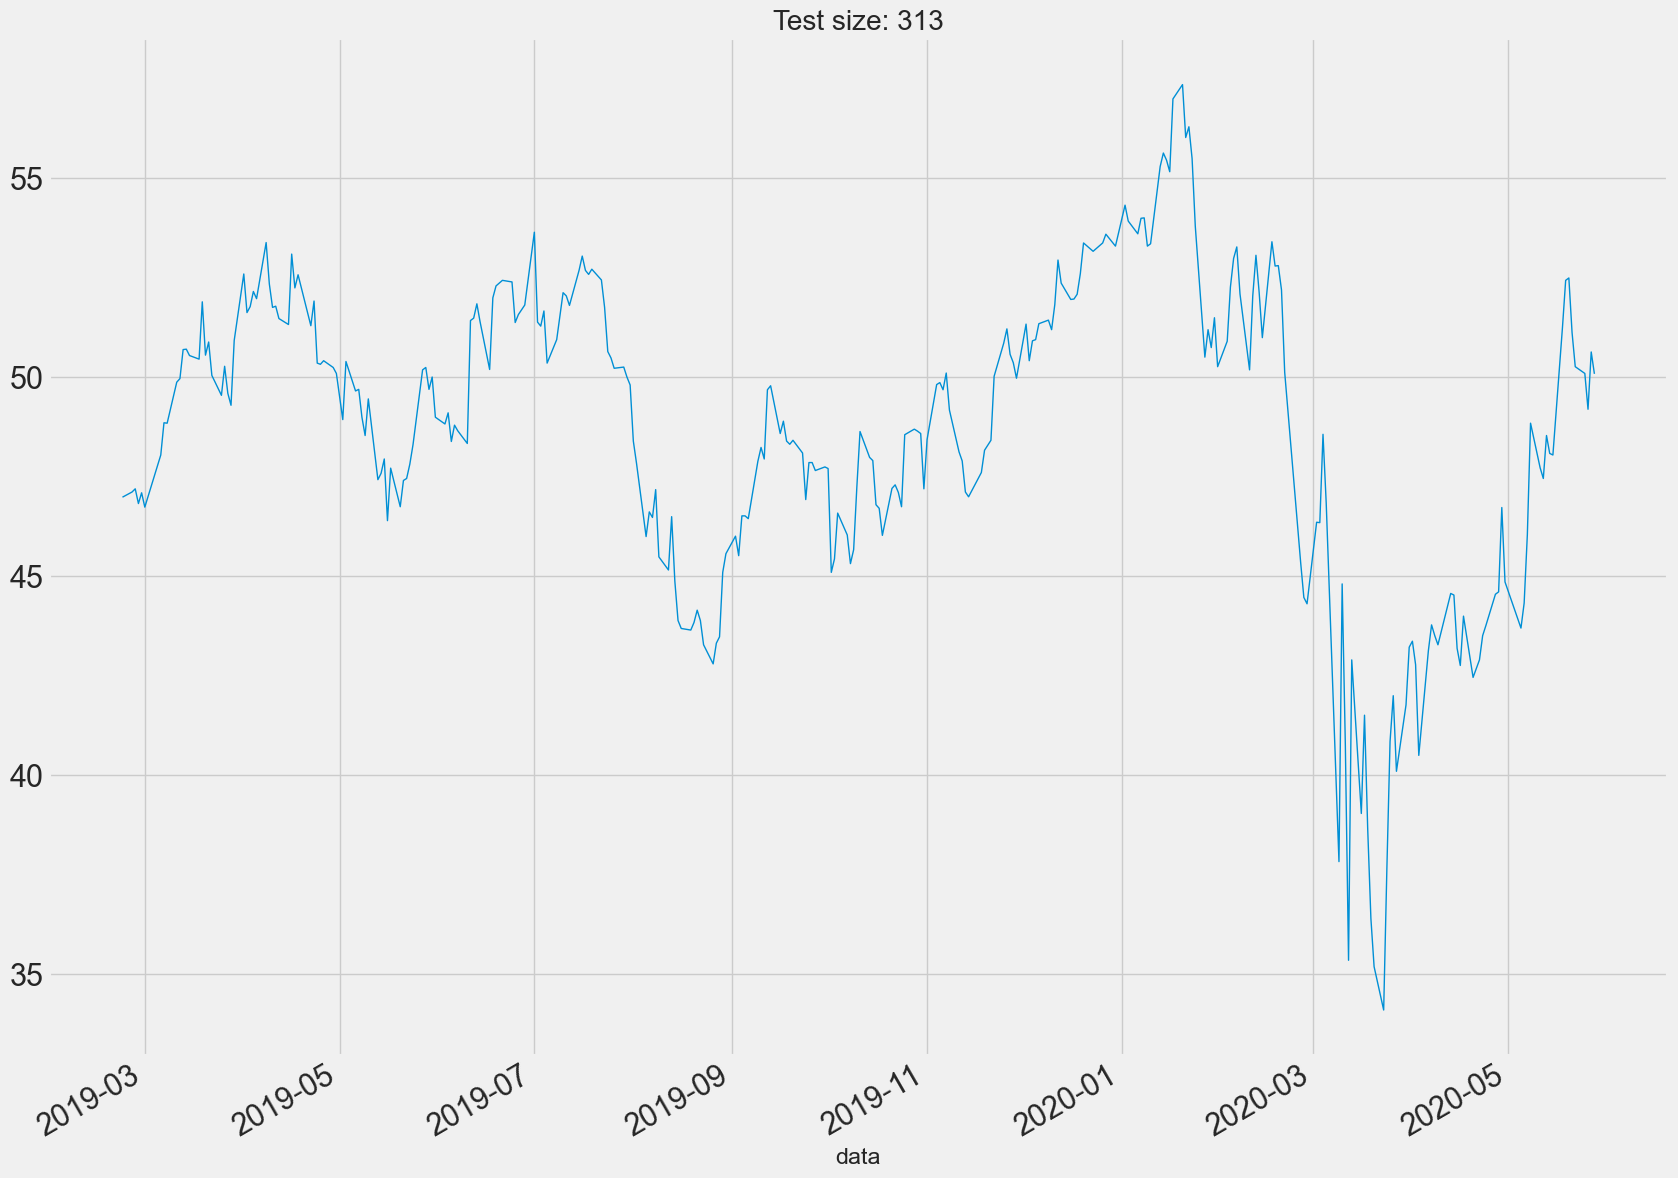

In [15]:
df_test['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [16]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)

In [17]:
df_test.index

DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', length=313, freq=None)

---

## **Evaluation**

In [18]:
dict_results = {}

## Modeling

In [19]:
train_max = df_train.max()
train_min = df_train.min()

train = (df_train - train_min)/(train_max - train_min)
test = (df_test - train_min)/(train_max - train_min)

In [20]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [21]:
time_steps = 1

X_train, y_train = create_dataset(train, train['preco'], time_steps)
X_test, y_test = create_dataset(test, test['preco'], time_steps)

### Build Model

#### LSTM
- reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [22]:
# sequential model
model_lstm = Sequential(name='lstm_vale3')
model_lstm

<Sequential name=lstm_vale3, built=False>

#### Input Layer

In [23]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=len(df_train.columns),
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [24]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10))
model_lstm.add(Dropout(0.2))

In [25]:
model_lstm.add(Dense(units=1))

In [26]:
model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['mse', 'mape'])

In [27]:
model_lstm.summary()

Model: "lstm_vale3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 9)           │           684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 10)          │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,175 (12.40 KB)

 Trainable params: 3,175 (12.40 KB)

 Non-trainable params: 0 (0.00 B)

### Training
batch_size: batches with 30 days

In [28]:
%%time
history = model_lstm.fit(X_train,
                         y_train,
                         epochs=1000,
                         batch_size=30,
                         shuffle=False,
                         validation_split=0.30,
                         verbose=0)
history

CPU times: user 8min 34s, sys: 1min 16s, total: 9min 51s
Wall time: 6min 18s


In [29]:
print(history.history.keys())

dict_keys(['loss', 'mape', 'mse', 'val_loss', 'val_mape', 'val_mse'])


In [39]:
best_epochs = history.history["loss"].index(min(history.history["loss"]))
best_epochs

959

In [30]:
min(history.history["loss"])

0.00222982419654727

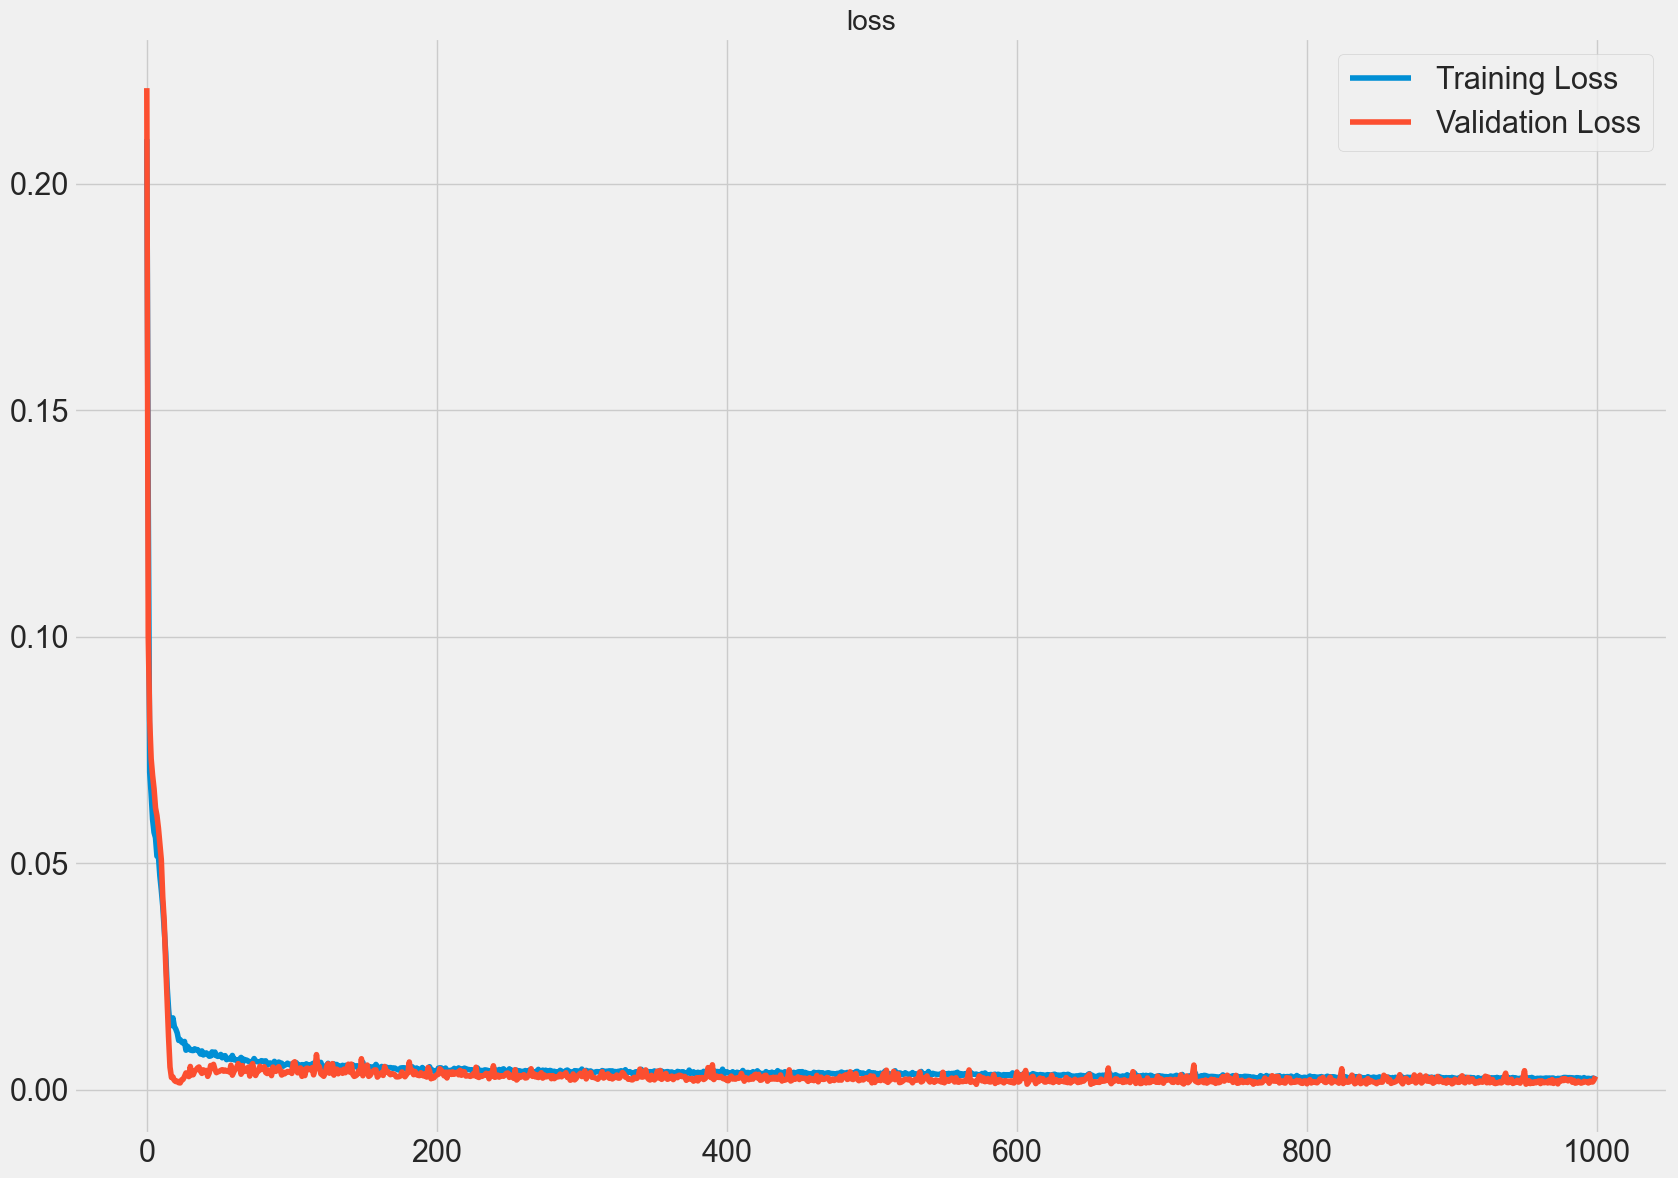

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('loss')
plt.legend()
plt.show()

---

### Predicts

In [32]:
y_pred = model_lstm.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [33]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

array([47.120003, 47.199997, 46.83    , 47.1     , 46.739998, 48.049995,
       48.86    , 48.85    , 49.879997, 49.97    ], dtype=float32)

In [47]:
y_test[:10]
y_train[:10]
print(len(y_train))
print(len(y_test))

2131
312


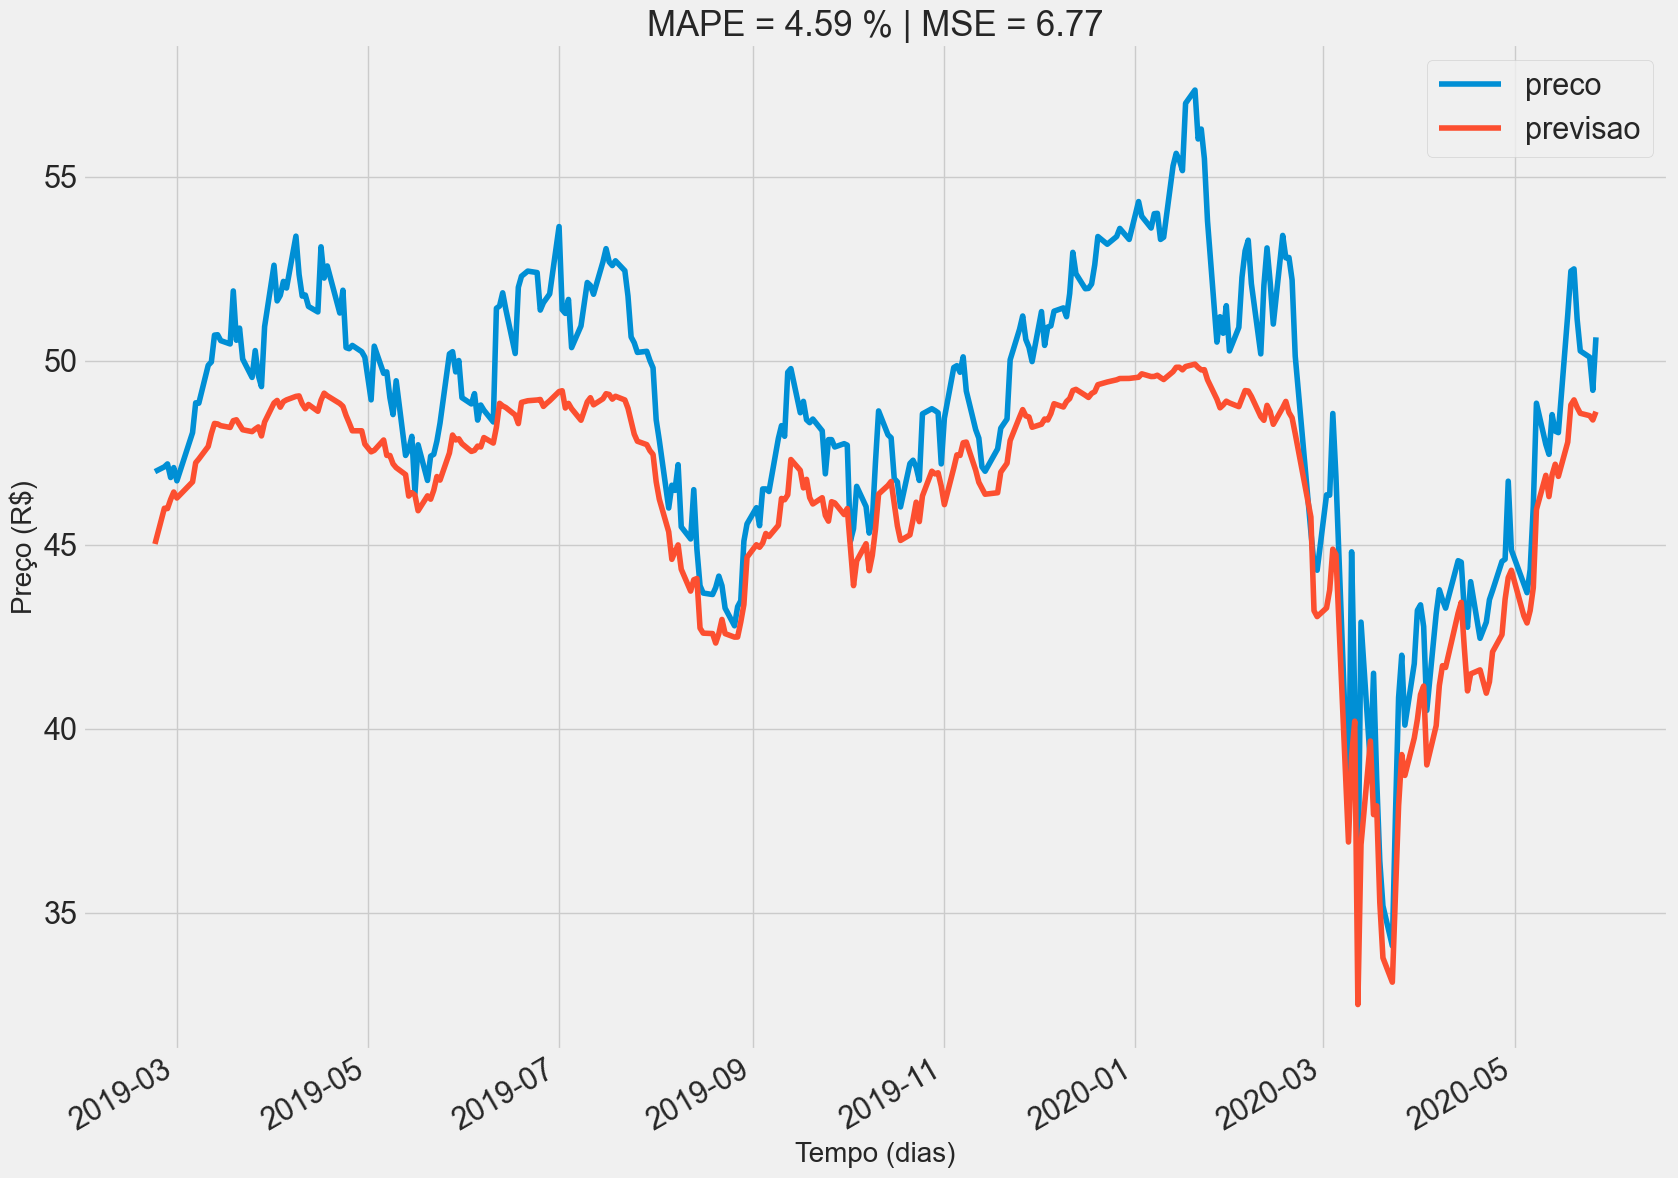

In [38]:
show_result_model(df_test=df_test['preco'][:312],
                  y_forecast=y_pred[:312],
                  model_name='model_lstm',
                  dict_results=dict_results)

---

## **Results**

In [48]:
dict_results

{'model_lstm': [2.1736652054111882, 2.223096210733722]}

---
